In [52]:
# Import libraries and set desired options
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html


from datetime import datetime

In [53]:
PATH_TO_DATA = 'Data'
SEED = 17

In [54]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y = None, groups = None):
        n_samples = X.shape[0]
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop] 

In [55]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

**By running the above function, we get sparse train and test matrices (`X_train_sites`, `X_test_sites`), vector of train targets `y_train` (0's and 1's - whether a session belongs to Alice or not), an instance of `TfidfVectorizer` (we'll need site name from it) and site visit times both for training and test sets, for further feature engineering. Go back to the function defined above, read comments, and experiment yourself to understand what we've done here.**

In [56]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 100000,
                       'tokenizer': lambda s: s.split()}
)

CPU times: user 24.9 s, sys: 560 ms, total: 25.5 s
Wall time: 23.2 s


In [57]:
print(X_train_sites.shape, X_test_sites.shape)

(253561, 100000) (82797, 100000)


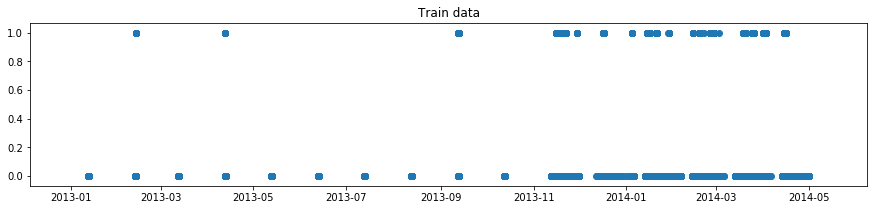

In [58]:
fig  = plt.figure(figsize = (15, 3))
plt.scatter(train_times['time1'], y_train)
plt.title('Train data')
plt.show()

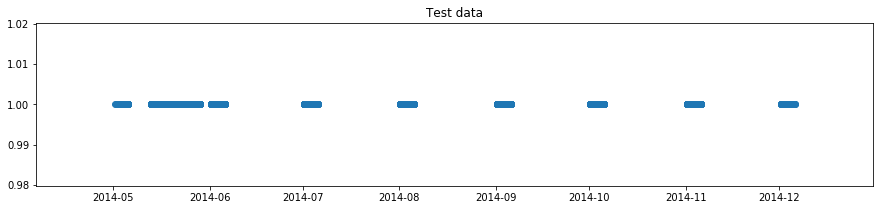

In [59]:
fig  = plt.figure(figsize = (15, 3))
plt.scatter(test_times['time1'].to_numpy(), np.ones((len(test_times), )))
plt.title('Test data')
plt.show()

## Submission 1: "Bag of sites" baseline

**We'll start with basic site features, applying the "bag of words" approach. Here we read training and test sets, sort train set by session start time.**

**These are basic features - sequences of visited web-sites.**

In [60]:
vectorizer.get_feature_names()[:10]

['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com 0.talkgadget.google.com',
 '0.docs.google.com 0.docs.google.com apis.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com 0.talkgadget.google.com']

In [61]:
vectorizer.get_feature_names()[10000:10010]

['apr.lijit.com vap5iad3.lijit.com vap5iad3.lijit.com apr.lijit.com',
 'apr.lijit.com www.audienceinsights.net',
 'apr.lijit.com www.audienceinsights.net rtbp-pixel.us.metanetwork.net',
 'apr.lijit.com www.facebook.com',
 'apr.lijit.com www.google.fr',
 'aps.toshiba-tro.de',
 'aps.toshiba-tro.de aps.toshiba-tro.de',
 'aquaportail.disqus.com',
 'aquitaine.france3.fr',
 'aqvatarius.com']

**We'll be performing time series cross-validation, see [the previous kernel](https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme) for an explanation.**

In [62]:
time_split = TimeSeriesSplit(n_splits=5)

**Perform time series cross-validation with logistic regression.**

In [63]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [64]:
%%time

cv_scores1 = cross_val_score(logit, X_train_sites, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4) # hangs with n_jobs > 1, and locally this runs much faster

CPU times: user 28 ms, sys: 44.1 ms, total: 72.2 ms
Wall time: 1.82 s


In [65]:
cv_scores1, cv_scores1.mean()

(array([0.70007379, 0.80772772, 0.88078293, 0.8805854 , 0.9273049 ]),
 0.8392949488664977)

**Train logistic regression with all training data**

In [66]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Display model weights with eli5**

In [67]:
eli5.show_weights(estimator=logit, 
                  feature_names=vectorizer.get_feature_names(), top=30)

Weight?,Feature
+6.183,youwatch.org
+5.558,vk.com
+5.253,fr.glee.wikia.com
+5.211,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.882,www.info-jeunes.net
+4.435,www.audienceinsights.net
+4.387,www.banque-chalus.fr
+4.337,www.melty.fr
+4.171,r4---sn-gxo5uxg-jqbe.googlevideo.com
+4.028,i1.ytimg.com


**Now we see which sites are descriptive of Alice. At the same time we notice that Alice doesn't use Gmail and Google Plus. Let's make predictions for test set and form a submission file.**

In [68]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [69]:
logit_test_pred = logit.predict_proba(X_test_sites)[:, 1]
write_to_submission_file(logit_test_pred, 'Predictions/subm1_mod_f5.csv') 

**We are going to repeat these steps several more times. It's a nice practice to substitute repeated chunks of code with function calls. So let's write a function which performs cross-validation, model training, displaying feature importance, making predictions for a test set and forming a submission file.**

In [70]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [71]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train_sites, y_train=y_train, 
                  X_test=X_test_sites, site_feature_names=vectorizer.get_feature_names(),              
                  cv=time_split, submission_file_name='Predictions/subm1_mod_f5.csv')

CV scores [0.70007379 0.80772772 0.88078293 0.8805854  0.9273049 ]
CV mean: 0.8392949488664977, CV std: 0.0794366766955407


Weight?,Feature
+6.183,youwatch.org
+5.558,vk.com
+5.253,fr.glee.wikia.com
+5.211,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.882,www.info-jeunes.net
+4.435,www.audienceinsights.net
+4.387,www.banque-chalus.fr
+4.337,www.melty.fr
+4.171,r4---sn-gxo5uxg-jqbe.googlevideo.com
+4.028,i1.ytimg.com


## Submission 2: Coming up with time features via EDA
Here we'll build just a few plots to motivate feature engineering. While competing, you'll need to create much more plots and build more features based on your observations. Take a look at [Kernels](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/kernels?sortBy=voteCount&group=everyone&pageSize=20&competitionId=7173) for this competition, eg. at [this "Initial EDA"](https://www.kaggle.com/adityaecdrid/initial-eda). You can do much more with sites, but let's switch to site visit times.

We've got an intuition: different people might prefer to visit (even the same) sites at *different* times of the day. Let's first draw the distribution of all session start hours. 

In [72]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

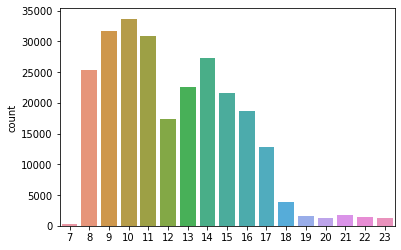

In [73]:
sns.countplot(session_start_hour);

Now the same separately for Alice and everybody else.

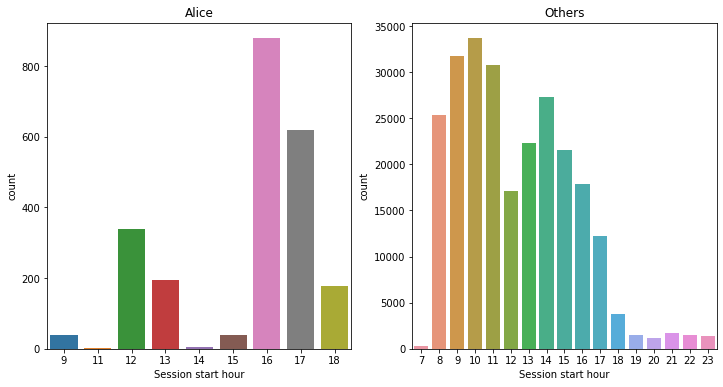

In [74]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

Now we definitely see that Alice mostly prefers 4-5 pm for browsing. So let's create features 'morning', 'day' and 'evening' and 'night'. Separators between these times of the day will be almost arbitrary: 0 am, 7 am, 12 am, and 7 pm. However, you can tune this.

In [75]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [76]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

### Categorical features

**Let's create a separate function to add new features (this will keep the code cleaner). To demonstrate possible overfitting, we'll keep a flag - whether to add an `hour` feature or not.**

In [77]:
def add_time_features(times, X_sparse):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']
    
#     if add_hour:
#         # we'll do it right and scale hour dividing by 24
#         objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
#         feature_names.append('hour')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [78]:
%%time
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

CPU times: user 2.2 s, sys: 55.8 ms, total: 2.26 s
Wall time: 1.37 s


In [79]:
X_train_with_times1.shape, X_test_with_times1.shape

((253561, 100004), (82797, 100004))

**Performing time series cross-validation, we see an improvement in ROC AUC.**

In [80]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train, 
                               X_test=X_test_with_times1, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='Predictions/subm2_mod_f5.csv')

CV scores [0.83715589 0.89002537 0.94130759 0.94743197 0.95318277]
CV mean: 0.9138207183135473, CV std: 0.04444846447659863


Weight?,Feature
+5.484,youwatch.org
+5.194,vk.com
+4.941,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.689,fr.glee.wikia.com
+4.628,www.melty.fr
+4.542,www.info-jeunes.net
+4.390,www.express.co.uk
+4.339,www.audienceinsights.net
+4.003,www.banque-chalus.fr
+3.947,i1.ytimg.com


New feature weights:
   feature      coef
0  morning -3.176347
1      day  0.545545
2  evening -2.711428
3    night  0.000000


**We see an improvement almost for all folds as compared to the results of previous cross-validation.**

In [81]:
cv_scores2 > cv_scores1

array([ True,  True,  True,  True,  True])

In [82]:
def plot_folds_scores(cv_scores_new, cv_scores_old):
    temp_data = np.hstack([cv_scores_new.reshape(-1, 1), cv_scores_old.reshape(-1, 1)])
    x = np.arange(len(temp_data))
    plt.plot(x, temp_data[:, 0], label = 'new ')
    plt.plot(x, temp_data[:, 1], label = 'old')
    plt.xlabel('Fold number')
    plt.ylabel('ROC AUC score')
    plt.legend()
    plt.show()

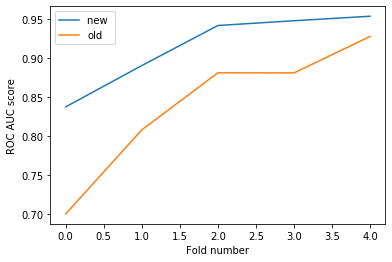

In [83]:
plot_folds_scores(cv_scores2, cv_scores1)

### Diffs and max len

In [84]:
def make_diffs_and_session_length(df_time):
    time_diffs =  (np.diff(df_time.to_numpy(), axis = 1)/1e9).astype(int)
    time_diffs = np.where(time_diffs < 0, 0, time_diffs)
    time_diffs = time_diffs[:, :] # useless
    
    session_length = ((np.max(df_time, axis = 1) - np.min(df_time, axis = 1))/1e9).astype(int)
    
    result = np.hstack([time_diffs, session_length.to_numpy().reshape(-1, 1)])
    
    
    return result

In [85]:
train_diffs = make_diffs_and_session_length(train_times)
test_diffs = make_diffs_and_session_length(test_times)

diff_features = ['diff{}'.format(i) for i in range(1, 10)] + ['session_length']

In [86]:
scaler = StandardScaler()
train_diffs_scaled = scaler.fit_transform(train_diffs)
test_diffs_scaled = scaler.transform(test_diffs)

In [87]:
X_train_with_time_correct = hstack([X_train_with_times1, train_diffs_scaled])
X_test_with_time_correct = hstack([X_test_with_times1, test_diffs_scaled])

In [88]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train, 
                               X_test=X_test_with_time_correct, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + diff_features,
                               cv=time_split, submission_file_name='Predictions/subm4_mod_f5.csv')

CV scores [0.83586943 0.88497615 0.94195859 0.9491614  0.95378326]
CV mean: 0.9131497666447711, CV std: 0.045921388176364465


Weight?,Feature
+5.457,youwatch.org
+5.304,vk.com
+4.905,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.695,fr.glee.wikia.com
+4.625,www.melty.fr
+4.538,www.info-jeunes.net
+4.386,www.express.co.uk
+4.292,www.audienceinsights.net
+4.040,www.banque-chalus.fr
+3.904,i1.ytimg.com


New feature weights:
           feature      coef
0          morning -3.202950
1              day  0.520694
2          evening -2.715482
3            night  0.000000
4            diff1 -0.051734
5            diff2 -0.008750
6            diff3  0.017761
7            diff4 -0.047223
8            diff5  0.039634
9            diff6 -0.030680
10           diff7 -0.032076
11           diff8 -0.226874
12           diff9 -0.173538
13  session_length -0.125055


In [89]:
cv_scores4 > cv_scores2

array([False, False,  True,  True,  True])

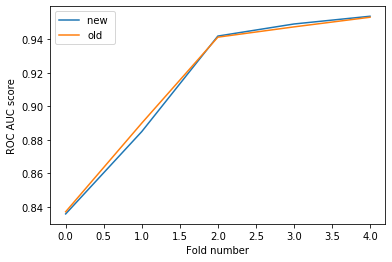

In [90]:
plot_folds_scores(cv_scores4, cv_scores2)

###  Adding more time features

In a real competition it's very important to keep track of Public Kernels and borrow some ideas form them.  For instance, we can explore [this Kernel](https://www.kaggle.com/hakeydotcom/additional-time-features-and-logit) and decide to add to features: day of week and month. In this case it's easy to come up to such features on your own, but still typically there's a lot to find out in Kernels.  

In [91]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    objects_to_hstack = [X_sparse, day_of_week, month,  year_month]
    feature_names = ['day_of_week', 'month', ' year_month']
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [92]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

In [93]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + diff_features + more_feat_names,
                               cv=time_split, submission_file_name='Predictions/subm6_mod_f5.csv')

CV scores [0.81810512 0.88850841 0.93909309 0.95775481 0.96848563]
CV mean: 0.9143894120857198, CV std: 0.05542151598457012


Weight?,Feature
+5.425,youwatch.org
+5.318,vk.com
+4.839,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.710,www.melty.fr
+4.700,www.info-jeunes.net
+4.482,www.audienceinsights.net
+4.474,fr.glee.wikia.com
+4.439,www.express.co.uk
+4.076,i1.ytimg.com
+3.922,www.banque-chalus.fr


New feature weights:
           feature      coef
0          morning -1.645120
1              day  2.056274
2          evening -1.736758
3            night  0.000000
4            diff1 -0.058317
5            diff2 -0.007015
6            diff3  0.016905
7            diff4 -0.046082
8            diff5  0.035404
9            diff6 -0.036452
10           diff7 -0.047832
11           diff8 -0.224392
12           diff9 -0.173906
13  session_length -0.132317
14     day_of_week -0.365198
15           month  0.106566
16      year_month -2.725844


In [94]:
cv_scores6 > cv_scores4

array([False,  True, False,  True,  True])

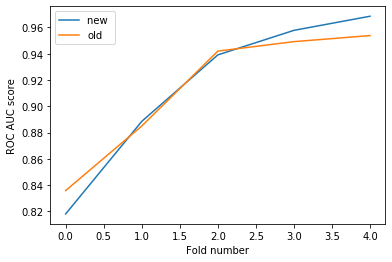

In [95]:
plot_folds_scores(cv_scores6, cv_scores4)

In [96]:
### 0.95041

## Submission 3: Tuning params
When you're done with feature engineering (no more ideas) you can tune hyperparameters in your model. Typically, at this point you create nice code for your pipeline, and then tune various params for a long time. Here we used several params - `ngram_range`, `max_features`. Choosing between `CountVectorizer` and `TfIdfVectorizer` might also be treated as a hyperparameter. But now we'll tune only regularization strength `C`.

In [97]:
param_grid_1 = {'C': np.logspace(-2, 2, 20),
              'class_weight': [None, 'balanced'],
              'solver': ['liblinear']}

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid=param_grid_1,
                                  scoring='roc_auc', n_jobs=4, cv=time_split, verbose=1)

In [98]:
%%time
#7 min
logit_grid_searcher.fit(X_train_final, y_train); 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 10.5min finished


CPU times: user 1min 3s, sys: 1.1 s, total: 1min 4s
Wall time: 10min 48s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='war...
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
         

In [99]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

# (0.9152334199355167,
#  {'C': 2.06913808111479, 'class_weight': None, 'solver': 'liblinear'})

(0.9156747537584667,
 {'C': 2.06913808111479, 'class_weight': None, 'solver': 'liblinear'})

In [100]:
final_model = logit_grid_searcher.best_estimator_

In [101]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + diff_features + more_feat_names,
                               cv=time_split, submission_file_name='Predictions/subm7_mod_tune1_f5.csv')

CV scores [0.81833917 0.89507233 0.94022706 0.95581217 0.96892303]
CV mean: 0.9156747537584667, CV std: 0.054677020689465713


Weight?,Feature
+7.610,www.express.co.uk
+7.563,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.778,youwatch.org
+5.658,vk.com
+5.587,tru.am
+5.489,fr.glee.wikia.com
+5.143,www.melty.fr
+5.099,www.info-jeunes.net
+5.031,www.activistpost.com
+4.940,www.banque-chalus.fr


New feature weights:
           feature      coef
0          morning -1.528964
1              day  2.201383
2          evening -2.074926
3            night  0.000000
4            diff1 -0.057965
5            diff2 -0.002904
6            diff3  0.026856
7            diff4 -0.046982
8            diff5  0.035812
9            diff6 -0.034990
10           diff7 -0.042042
11           diff8 -0.204508
12           diff9 -0.149170
13  session_length -0.115732
14     day_of_week -0.362439
15           month  0.116078
16      year_month -2.941690


In [102]:
cv_scores7 > cv_scores6

##0.95129.

array([ True,  True,  True, False,  True])